In [1]:
# Australian Geoscience Datacube
## Feature Summary Examples

The [Australian Geoscience Datacube](https://github.com/data-cube/agdc-v2) provides an integrated gridded data analysis environment for decades of analysis ready earth observation satellite and related data from multiple satellite and other acquisition systems.

For instructions on using the Datacube on NCI, see: http://agdc-v2.readthedocs.io/en/develop/nci_usage.html

For instructions on setting up your own instance, see: http://agdc-v2.readthedocs.io/en/develop/install.html

This notebook touches briefly on some the implimented features of the Datacube module, and is only intended to deomstrat functionality rather than be a tutorial.

In [2]:
%pylab notebook
#%pylab inline
#%matplotlib inline
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
import matplotlib.dates
import json
import pandas as pd
from IPython.display import display
import ipywidgets as widgets
import fiona
import shapely
import shapely.geometry
from shapely.geometry import shape
import rasterio
import matplotlib.gridspec as gridspec


Populating the interactive namespace from numpy and matplotlib


If you have set up your config correctly, or are using the module on NCI, you should be able to make `Datacube` object that can connects to the configured datacube system.

In [3]:
dc = datacube.Datacube(app='dc-example')
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://lxl554@130.56.244.227:6432/datacube)>>>

## Datacube products and measurements
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [4]:
#dc.list_products()

## Datacube Measurements
The list of measurements stored in the datacube can also be listed.

Measurements are also known as _bands_ in the imagery domain, and _data variables_ when stored in NetCDF files or when working with `xarray.Dataset` objects.

In [5]:
#dc.list_measurements()

In [6]:
def geom_query(geom, geom_crs='EPSG:4326'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }


def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    
    """
    dist = [i for i in range(0, int(geom.length), resolution)]
    points = zip(*[geom.interpolate(d).coords[0] for d in dist])
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)

In [7]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Either as polygon or as lat/lon range


vec_fname = '/g/data/r78/lxl554/hovmoller/goolwa_barrage1.shp' #comment these lines out if running without polygon
src = fiona.open(vec_fname)
geom = shape(src[0]['geometry'])




#Define temporal range
start_of_epoch = '1987-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest - this needs to remain unchanged as I've put sensor specific coefficients against
# these sensors
sensor1 = 'ls8'
sensor2 = 'ls7'
sensor3 = 'ls5'

query = {
    'time': (start_of_epoch, end_of_epoch),
}

query.update(geom_query(geom)) #comment this out if not using a polygon

#If not using a polygon/polyline, enter lat/lon here manually
"""lat_max = -32.83
lat_min = -32.86
lon_max = 147.55
lon_min = 147.45
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'"""

"lat_max = -32.83\nlat_min = -32.86\nlon_max = 147.55\nlon_min = 147.45\nquery['x'] = (lon_min, lon_max)\nquery['y'] = (lat_max, lat_min)\nquery['crs'] = 'EPSG:4326'"

In [8]:
print query

{'y': (-35.52755355174274, -35.51815334458937), 'x': (138.8007303447449, 138.8244223839475), 'crs': 'EPSG:4326', 'time': ('1987-01-01', '2016-12-31')}


## Retrieve surface reflectance data


In [9]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensor1+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

In [10]:
#load sensor specific band adjustment tuples for TSS and brightness

In [11]:
#load sensor specific band adjustment tuples for TSS 
ls5_tss_constant = 3983
ls5_tss_exponent = 1.6246
ls7_tss_constant = 3983
ls7_tss_exponent = 1.6246
ls8_tss_constant = 3957
ls8_tss_exponent = 1.6436

# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [12]:
#Retrieve the NBAR and PQ data for sensor n
sensor1_nbar = dc.load(product= sensor1+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor1_pq = dc.load(product= sensor1+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
            

In [13]:
crs = sensor1_nbar.crs
crswkt = sensor1_nbar.crs.wkt

affine = sensor1_nbar.affine

In [14]:
#This line exists to make sure that there's a 1:1 match between NBAR and PQ
sensor1_nbar = sensor1_nbar.sel(time = sensor1_pq.time)

In [15]:
#Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
s1_cloud_free = masking.make_mask(sensor1_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor1_nbar = sensor1_nbar.where(s1_good_data)

In [16]:
#Fix the TSS coefficients for each sensor
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NBR','NDWI','TSS']
sensor1_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor1_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor1_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor1_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    sensor1_rsindex['NDVI'] = ((sensor1_nbar['nir']-sensor1_nbar['red'])/(sensor1_nbar['nir']+sensor1_nbar['red']))
    #sensor1_rsindex['NDWI'] = ((sensor1_nbar['swir1']-sensor1_nbar['green'])/(sensor1_nbar['swir1']+sensor1_nbar['green']))
    #sensor1_rsindex['NBR'] = ((sensor1_nbar['nir']-sensor1_nbar['swir2'])/(sensor1_nbar['nir']+sensor1_nbar['swir2']))
    #Need this to reference into a tuple - Check with Damien    
    sensor1_rsindex['TSS'] = (ls8_tss_constant*((sensor1_nbar['green']+sensor1_nbar['red'])/20000)**ls8_tss_exponent)

In [17]:
sensor2_nbar = dc.load(product= sensor2+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor2_pq = dc.load(product= sensor2+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [18]:
sensor2_nbar = sensor2_nbar.sel(time = sensor2_pq.time)

In [19]:
s2_cloud_free = masking.make_mask(sensor2_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s2_good_data = s2_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor2_nbar = sensor2_nbar.where(s2_good_data)

In [20]:
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NBR', 'NDWI','TSS']
sensor2_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor2_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor2_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor2_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    sensor2_rsindex['NDVI'] = ((sensor2_nbar['nir']-sensor2_nbar['red'])/(sensor2_nbar['nir']+sensor2_nbar['red']))
    #sensor2_rsindex['NDWI'] = ((sensor2_nbar['swir1']-sensor2_nbar['green'])/(sensor2_nbar['swir1']+sensor2_nbar['green']))
    #sensor2_rsindex['NBR'] = ((sensor2_nbar['nir']-sensor2_nbar['swir2'])/(sensor2_nbar['nir']+sensor2_nbar['swir2']))
    sensor2_rsindex['TSS'] = (ls7_tss_constant*((sensor2_nbar['green']+sensor2_nbar['red'])/20000)**ls7_tss_exponent)


In [21]:
sensor3_nbar = dc.load(product= sensor3+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor3_pq = dc.load(product= sensor3+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [22]:
sensor3_nbar = sensor3_nbar.sel(time = sensor3_pq.time)

In [23]:
s3_cloud_free = masking.make_mask(sensor3_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s3_good_data = s3_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor3_nbar = sensor3_nbar.where(s3_good_data)

In [24]:
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NBR', 'NDWI','TSS']
sensor3_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor2_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor2_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor2_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    sensor3_rsindex['NDVI'] = ((sensor3_nbar['nir']-sensor3_nbar['red'])/(sensor3_nbar['nir']+sensor3_nbar['red']))
    #sensor3_rsindex['NDWI'] = ((sensor3_nbar['swir1']-sensor3_nbar['green'])/(sensor3_nbar['swir1']+sensor3_nbar['green']))
    #sensor3_rsindex['NBR'] = ((sensor3_nbar['nir']-sensor3_nbar['swir2'])/(sensor3_nbar['nir']+sensor3_nbar['swir2']))
    #sensor3_rsindex['TSS'] = ((sensor3_nbar['green']+sensor3_nbar['red'])/2)
    sensor3_rsindex['TSS'] = (ls5_tss_constant*((sensor3_nbar['green']+sensor3_nbar['red'])/20000)**ls5_tss_exponent)


## Combining data from multiple sensors
Having masked out cloud and cloud shadow affected pixels and calculated various indices we can now combine the measurements from the different sensors to create full depth time series

In [25]:
#Concatenate and sort the different sensor xarrays into a single xarray

nbar_clean = xr.concat([sensor1_nbar, sensor2_nbar, sensor3_nbar], dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine

all_tss_sorted = xr.concat([sensor1_rsindex['TSS'], sensor2_rsindex['TSS'], sensor3_rsindex['TSS']], dim='time')
time_sorted = all_tss_sorted.time.argsort()
all_tss_sorted = all_tss_sorted.isel(time=time_sorted)
all_tss_sorted.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine

#Turn this on if you want to be able to look at the relationship between vegetation greenness and water quality
"""all_ndvi_sorted = xr.concat([sensor1_rsindex['NDVI'], sensor2_rsindex['NDVI'], sensor3_rsindex['NDVI']], dim='time')
time_sorted = all_ndvi_sorted.time.argsort()
all_ndvi_sorted = all_ndvi_sorted.isel(time=time_sorted)
all_ndvi_sorted.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine"""



"all_nbr_sorted = xr.concat([sensor1_rsindex['NBR'], sensor2_rsindex['NBR'], sensor3_rsindex['NBR']], dim='time')\ntime_sorted = all_nbr_sorted.time.argsort()\nall_nbr_sorted = all_nbr_sorted.isel(time=time_sorted)\nall_nbr_sorted.attrs['crs'] = crs\nnbar_clean.attrs['affine'] = affine\n"

In [26]:
#clean up per sensor xarrays to free up some memory
del sensor1_nbar
del sensor2_nbar
del sensor3_nbar
del sensor1_rsindex
del sensor2_rsindex
del sensor3_rsindex

## Plotting a multi-band image

In [31]:
geom_w = warp_geometry(geom, query['crs'], crs.wkt)
trans = transect(all_tss_sorted, geom_w, 25)
print 'The number of time slices at this location is ' +str(nbar_clean.red.shape[0])


The number of time slices at this location is 478


In [28]:
#select time slice of interest - it's a bit of trial and error here to get a nice image to work with
time_slice = 3
rgb = nbar_clean.isel(time =time_slice).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 4500
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

<IPython.core.display.Javascript object>


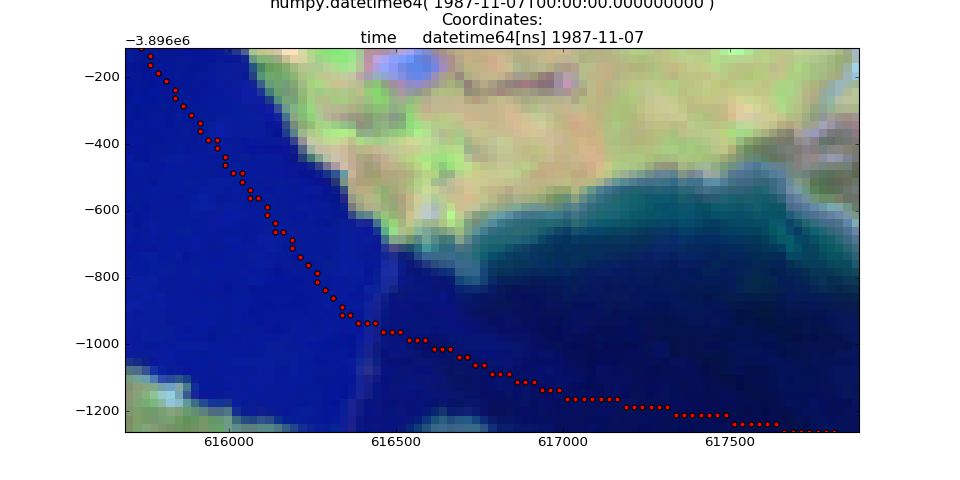

In [32]:
#Click on this image to chose the location for the time series extraction
w = widgets.HTML("Event information appears here when you click on the figure")


def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(12,6))
plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r')

plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])

#plt.grid(True)
fig.canvas.mpl_connect('button_press_event', callback)
date_ = nbar_clean.time[time_slice]
plt.title(date_.astype('datetime64[D]'))
plt.show()
display(w)

### This shows you which location you've selected for time series analysis (yellow dot)

<IPython.core.display.Javascript object>


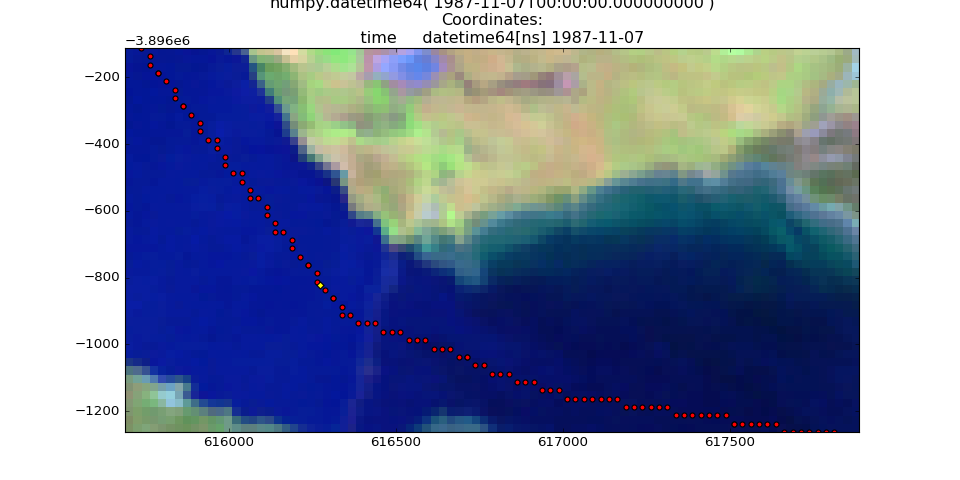

In [33]:
fig = plt.figure(figsize =(12,6))
plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r')
plt.scatter(x = [x], y = [y], c= 'yellow', marker = 'D')

plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])

fig.canvas.mpl_connect('button_press_event', callback)
date_ = nbar_clean.time[time_slice]
plt.title(date_.astype('datetime64[D]'))
plt.show()

In [34]:
#this converts the map x coordinate into image x coordinates
image_coords = ~nbar_clean.affine * (x, y)
imagex = int(image_coords[0])
imagey = int(image_coords[1])

## Interact with a time series and select a point of interest - to view as an image

<IPython.core.display.Javascript object>


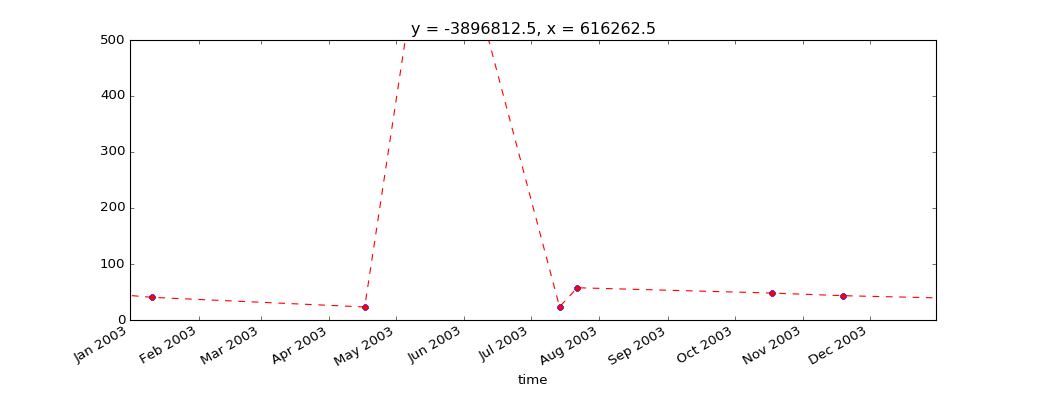

In [70]:
#Use this plot to visualise TSS time series and select the image that corresponds with a point in the time series
def callback(event):
    global time_int, devent
    devent = event
    time_int = event.xdata
    #time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)



fig = plt.figure(figsize=(13,5))
fig.canvas.mpl_connect('button_press_event', callback)

#Use first year and last year to constrain length of time series
firstyear = '2003-01-01'
lastyear = '2003-12-31'
#Use the max_tsm and min_tsm values to scale the y axis
min_tsm = 0
max_tsm = 500

all_tss_sorted.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r', marker = '8', mec = 'b', mfc ='r')

plt.axis([firstyear , lastyear , min_tsm, max_tsm])

plt.show()
display(w)


In [77]:
time_slice = matplotlib.dates.num2date(time_int).date()
rgb = nbar_clean.sel(time =time_slice, method = 'nearest').to_array(dim='color').sel(color=['red', 'green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2500
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled2 = (clipped_visible / max_val)

In [78]:
time_slice

datetime.date(2003, 11, 18)

<IPython.core.display.Javascript object>


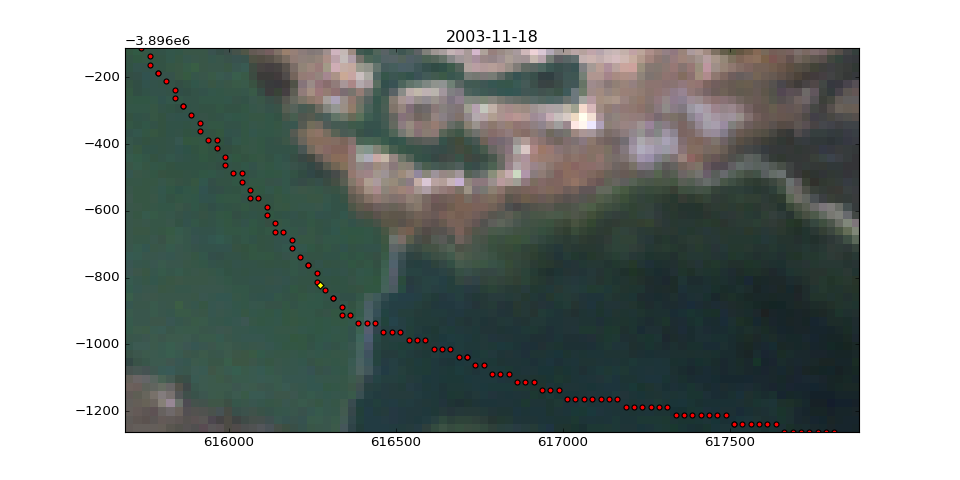

In [79]:
fig = plt.figure(figsize =(12,6))
plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r')
plt.scatter(x = [x], y = [y], c= 'yellow', marker = 'D')

plt.imshow(scaled2, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])

fig.canvas.mpl_connect('button_press_event', callback)
plt.title(time_slice)
plt.show()

## Generate Hovmoller plots for the transect

In [65]:
# Set the percentage of good data that you'd like to display with pernan variable - 0.9 will return rows that have 90%
# of valid values
pernan = 0.9
geom_w = warp_geometry(geom, query['crs'], crs.wkt)
trans = transect(all_tss_sorted, geom_w, 25)
trans_drop = transect(all_tss_sorted, geom_w, 25).dropna('time', how = 'any', thresh = int(pernan*trans.shape[0]))

#You can check below to see the number of time slices dropped
print 'The number of time slices unfiltered = ' + str(trans_drop.shape[1])
print 'The number of time slices filtered = '+ str(trans.shape[1])

The number of time slices unfiltered = 255
The number of time slices filtered = 478


<IPython.core.display.Javascript object>


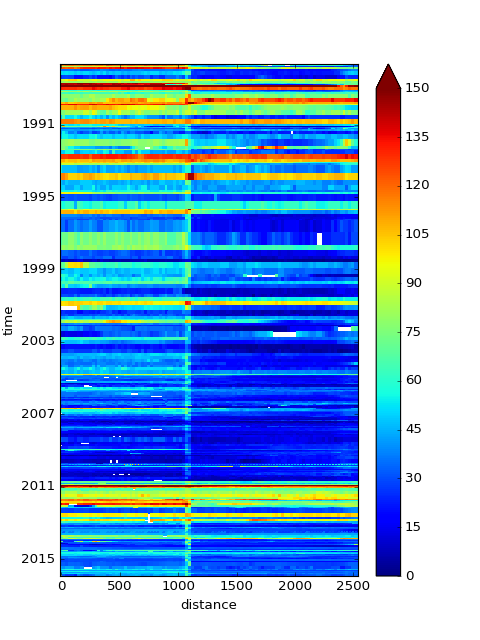

In [48]:
fig = plt.figure(figsize=(6,8))

trans_drop.plot(x='distance', y='time', vmin = 0, vmax = 150, yincrease = False, cmap = 'jet')

## Subset the Hovmoller plot to a period of interest

In [ ]:
fig = plt.figure(figsize=(11.69,8.27))
#use firstyear and last year to focus in on a particular epoch
firstyear = '2009-01-01'
lastyear = '2015-12-31'
trans_drop.plot(x='distance', y='time', vmin = 0, vmax = 150, yincrease = False)
plt.axis([0, trans_drop.coords['distance'].max(), lastyear , firstyear])

